In [1]:
include("src/nanoconc.jl")
using .nanoconc
using XLSX
using DataFrames
using Plots

In [2]:
function get_until_missing(sheet::XLSX.Worksheet)::Matrix{Any}
    x = 1
    while !ismissing(sheet[x, 1])
        x += 1
    end
    y = 1
    while !ismissing(sheet[1, y])
        y += 1
    end
    x -= 1
    y -= 1
    out_matrix = Matrix{Any}(undef, x, y)
    for i in 1:x
        for j in 1:y
            out_matrix[i, j] = sheet[i, j]
        end
    end
    return out_matrix
end

uv_data = XLSX.openxlsx("val_data/uv-vis/uv-vis.xlsx", enable_cache=false) do f
    let uv_matrix = let uv_sheet = f[1][:]
            uv_sheet[.!any.(ismissing, eachrow(uv_sheet)), :]
        end
        DataFrame(Matrix{Float64}(uv_matrix[2:end, :]), uv_matrix[1, :])
    end
end

size_data = Dict{String,DataFrame}()
d = "val_data/size"
for f in readdir(d)
    filepath = joinpath(d, f)
    sample_name = replace(f, "_RES_" => "", ".xlsx" => "")
    size_data[sample_name] = XLSX.openxlsx(filepath, enable_cache=false) do f
        let size_matrix = get_until_missing(f[1])
            let df = DataFrame(Matrix{Float64}(size_matrix[2:end, :]), [split(x, " ")[1] for x in size_matrix[1, :]])
                df[df[!, "Intensity"].!=0, :]
            end
        end
    end
end


In [3]:
refmed = 1.333 # refractive index of the medium
wavel1, wavel2 = 250.0, 700.0 # wavelengths to calculate between
numval = 0x00001000 # number of values to calculate in spectrum
materialdata = nanoconc.loadmaterial("Silver", disp=false)

(137.07406889988462, 0.26239882249654195, 1.390822860797353e8, [187.9 1.07 1.212; 191.6 1.1 1.232; … ; 1610.0 0.15 11.85; 1937.0 0.24 14.08])

In [4]:
using Interpolations
using QuadGK

In [5]:
ppml_data = Dict{String,UInt128}(
    "AG1" => 2446294100000,
    "AG2" => 12202461664800,
    "AG3" => 15655500000000000,
    "AG4" => 963800000000000000,
    "AG5" => 212801228000000,
    "AG6" => 13340000000000000,
    "AG7" => 35732125326000,
    "AG8" => 0x8db134e7b4bd0000,
    "AG9" => 2522020000000000,
    "AG10" => 5196191294900,
    "AG11" => 0xc9a4ee044a6d0000,
    "AG12" => 1922030000000000,
    "AG13" => 944162841600000,
    "AG14" => 0x00000000000000036bf3062ea8ed0000,
    "AG15" => 8130020000000000,
    "AG16" => 296412370000000,
    "AG17" => 59534649000000,
)

Dict{String, UInt128} with 17 entries:
  "AG12" => 0x00000000000000000006d4137b65cc00
  "AG17" => 0x0000000000000000000036257d9b0040
  "AG2"  => 0x000000000000000000000b191b649620
  "AG4"  => 0x00000000000000000d601afe5a858000
  "AG5"  => 0x00000000000000000000c18aa59a4b00
  "AG7"  => 0x00000000000000000000207f88a31ab0
  "AG8"  => 0x00000000000000008db134e7b4bd0000
  "AG9"  => 0x00000000000000000008f5c38a376800
  "AG11" => 0x0000000000000000c9a4ee044a6d0000
  "AG14" => 0x00000000000000036bf3062ea8ed0000
  "AG13" => 0x000000000000000000035ab60ac8a000
  "AG15" => 0x0000000000000000001ce235ca1de800
  "AG16" => 0x000000000000000000010d95e2055880
  "AG1"  => 0x000000000000000000000239927da820
  "AG6"  => 0x0000000000000000002f64a8c94dc000
  "AG10" => 0x0000000000000000000004b9d522e5b4
  "AG3"  => 0x000000000000000000379e982447f800

In [6]:
include("src/miemfp.jl")

Main.miemfp

In [33]:
struct q_to_sigma
    weighted_geometric_cross_section::Vector{Float64}
    total_weights::Float64

    function q_to_sigma(x::Matrix{Float64})::q_to_sigma
        radii = x[:, 1] .* 1e-9
        weights = x[:, 2]
        new(weights .* (π .* (radii .^ 2)), sum(weights))
    end
end

function (p::q_to_sigma)(q::Matrix{Float64})
    # Calculate the extinction cross-section
    test = sum([x .* q[:, 2] for x in p.weighted_geometric_cross_section]) ./ p.total_weights
    q[:, 2] = test
end

function (p::q_to_sigma)(q::Vector{Matrix{Float64}})
    for x in q
        p(x)
    end
end

function sigmapredict(refmed::Float64, wavel1::Float64, wavel2::Float64,
    numval::UInt32, particledata::Array{Float64,2},
    materialdata::Tuple{Float64,Float64,Float64,Array{Float64,2}}
)::Array{Float64,2}
    # normalise relative amounts of particles to a total of 1
    particledata[:, 2] = particledata[:, 2] ./ sum(particledata[:, 2])
    # convert particle diameters in particledata to radii
    particledata[:, 1] = particledata[:, 1] ./ 2
    # define a wrapper function for later vectorised calculations
    spec(x) = miemfp.qbare(wavel1, wavel2, numval, 0x00000002, refmed, x, materialdata...)
    # note: the UInt32 above for "scangles" must be at least 2 for accurate Qext. Higher "scangles"
    ##	does not increase Qext precision but will be important if modding to also account for Qsca
    # perform vectorised spectrum prediction on particledata array
    spectra = spec.(particledata[:, 1])::Vector{Matrix{Float64}}
    q_to_sigma(particledata)(spectra)
    # for each spectrum, multiply all values by their relative amounts from the particledata array
    @inbounds @simd for i in eachindex(spectra)
        spectra[i][:, 2] = particledata[i, 2] .* spectra[i][:, 2]
    end
    # prep an array for final predicted spectrum
    data::Array{Float64,2} = Array{Float64,2}(undef, numval, 2)
    data[:, 1] = spectra[1][:, 1]
    data[:, 2] = zeros(numval)
    # for each weighted spectrum, add it to the total spectrum in the "data" array
    @inbounds @simd for x in spectra
        data[:, 2] = data[:, 2] .+ x[:, 2]
    end
    return data
end

pred_uv_data = Dict{String,Matrix}()
for (k, v) in size_data
    pred_uv_data[k] = sigmapredict(refmed, wavel1, wavel2, numval, Matrix{Float64}(v), materialdata)
end

In [34]:
counts = Dict{String,UInt128}()
for (k, v) in pred_uv_data
    measured_area, _ = quadgk(LinearInterpolation(uv_data[!, "Wavelength"], uv_data[!, k]), wavel1, wavel2)
    pred_interp = LinearInterpolation(pred_uv_data[k][:, 1], pred_uv_data[k][:, 2])
    pred_area, _ = quadgk(pred_interp, wavel1, wavel2)
    actual = ppml_data[k]
    predicted = UInt128(round(measured_area / pred_area))
    counts[k] = predicted
    println("BY AREA: ", k, ": ", predicted, "(", (predicted / actual) * 100.0, "%)")
    pred_intensity = pred_interp(uv_data[!, "Wavelength"])
    rel_intensity = uv_data[!, k] ./ pred_intensity
    predicted = UInt128(round(sum(rel_intensity) / length(rel_intensity)))
    println("BY INTENSITY: ", k, ": ", predicted, " (", (predicted / actual) * 100.0, "%)")
end

BY AREA: AG4: 99891546128110(0.010364343860563395%)
BY INTENSITY: AG4: 354902794327222 (0.03682328225017867%)
BY AREA: AG14: 167496787156826(0.0002653675088196005%)
BY INTENSITY: AG14: 715736683242009 (0.0011339516645468687%)


BY AREA: AG13: 19900844840290(2.107776748189494%)
BY INTENSITY: AG13: 26380741605331 (2.79408810037743%)
BY AREA: AG16: 48126629765135(16.236376965352356%)
BY INTENSITY: AG16: 140653922687161 (47.45210960229527%)
BY AREA: AG10: 13841201270503(266.37204992987796%)
BY INTENSITY: AG10: 18299970127394 (352.18045466022784%)
BY AREA: AG12: 21738950932114(1.13104118729229%)
BY INTENSITY: AG12: 48373903507571 (2.516813135464639%)
BY AREA: AG17: 30602424501936(51.40271256480575%)
BY INTENSITY: AG17: 71888493699625 (120.75068033007972%)
BY AREA: AG2: 12321663398706(100.97686628469285%)
BY INTENSITY: AG2: 16211047801255 (132.85063495031025%)
BY AREA: AG11: 212854622964578(0.001464932023156077%)
BY INTENSITY: AG11: 903027163331146 (0.0062149150951902685%)
BY AREA: AG5: 21058317281309(9.89576868480712%)
BY INTENSITY: AG5: 31971097293818 (15.023925187977769%)
BY AREA: AG7: 12621607262196(35.32285624502738%)
BY INTENSITY: AG7: 19770659427437 (55.330208452647355%)
BY AREA: AG8: 158205761013457(0.00154

BY AREA: AG15: 32735084595125(0.402644576460144%)
BY INTENSITY: AG15: 68395561601672 (0.8412717508895672%)
BY AREA: AG1: 8341980646355(341.00481403094585%)
BY INTENSITY: AG1: 8659178836637 (353.971292194058%)
BY AREA: AG6: 68954423535853(0.5168997266555697%)
BY INTENSITY: AG6: 189277317427368 (1.4188704454825187%)
BY AREA: AG3: 18955584839239(0.12107939599015681%)
BY INTENSITY: AG3: 25950908683000 (0.16576224766376033%)


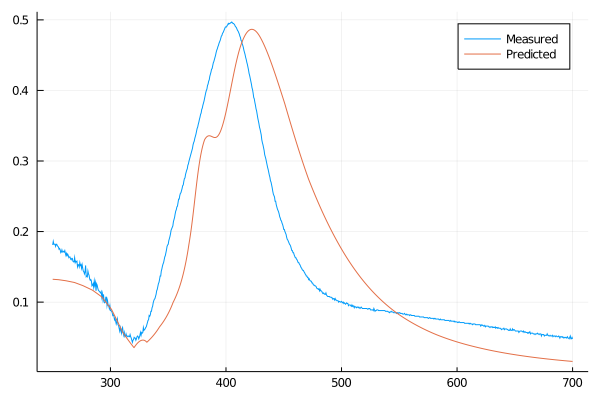

In [35]:
sample = "AG3"
plot(uv_data[!, "Wavelength"], uv_data[!, sample], label="Measured")
plot!(pred_uv_data[sample][:, 1], counts[sample] * pred_uv_data[sample][:, 2], label="Predicted")

In [25]:
dispinfo("Silver")


Material:		Silver
- Valence:		1.0
- Atomic Mass:		107.8682amu
- Density:		10.49g/cm^3
- Resistivity:		1.59e-8g/cm^3
Derived values:
- Plasma frequency:	137.07406889988462e14Hz
- Collision frequency:	0.26239882249654195e14Hz
- Fermi Velocity:	1.390822860797353e8cm/s
Wavelength Range:	187.9nm-1937.0nm
Number of datapoints:	49
Description:
"Refractive index data from Johnson & Christy (1972)"


In [31]:
loadmaterial("Gold")[4]


Loading material:

Material:		Gold
- Valence:		1.0
- Atomic Mass:		196.966569amu
- Density:		19.3g/cm^3
- Resistivity:		2.214e-8g/cm^3
Derived values:
- Plasma frequency:	217.6191453622e14Hz
- Collision frequency:	0.3681502558757682e14Hz
- Fermi Velocity:	1.3943315831262603e8cm/s
Wavelength Range:	187.9nm-1937.0nm
Number of datapoints:	49
Description:
"Refind data from Johnson & Christy, 1972"



49×3 Matrix{Float64}:
  187.9  1.28   1.188
  191.6  1.32   1.203
  195.3  1.34   1.226
  199.3  1.33   1.251
  203.3  1.33   1.277
  207.3  1.3    1.304
  211.9  1.3    1.35
  216.4  1.3    1.387
  221.4  1.3    1.427
  226.2  1.31   1.46
    ⋮          
  756.0  0.14   4.542
  821.1  0.16   5.083
  892.0  0.17   5.663
  984.0  0.22   6.35
 1088.0  0.27   7.15
 1216.0  0.35   8.145
 1393.0  0.43   9.519
 1610.0  0.56  11.21
 1937.0  0.92  13.78

In [28]:
materialdata[4]

49×3 Matrix{Float64}:
  187.9  1.07   1.212
  191.6  1.1    1.232
  195.3  1.12   1.255
  199.3  1.14   1.277
  203.3  1.15   1.296
  207.3  1.18   1.312
  211.9  1.2    1.325
  216.4  1.22   1.336
  221.4  1.25   1.342
  226.2  1.26   1.344
    ⋮          
  756.0  0.03   5.242
  821.1  0.04   5.727
  892.0  0.04   6.312
  984.0  0.04   6.992
 1088.0  0.04   7.795
 1216.0  0.09   8.828
 1393.0  0.13  10.1
 1610.0  0.15  11.85
 1937.0  0.24  14.08

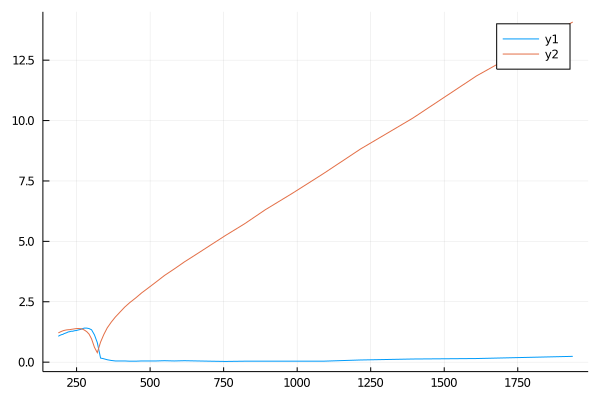

In [29]:
plot(materialdata[4][:,1], materialdata[4][:,2])
plot!(materialdata[4][:,1], materialdata[4][:,3])